In [1]:
# !pip install kaggle
# !mkdir ~/.kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99%|██████████████████████████████████████▋| 2.28G/2.29G [00:10<00:00, 180MB/s]
100%|███████████████████████████████████████| 2.29G/2.29G [00:10<00:00, 229MB/s]
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 99%|████████████████████████████████████████▌| 657M/663M [00:12<00:00, 187MB/s]
100%|████████████████████████████████████████| 663M/663M [00:12<00:00, 54.4MB/s]


In [2]:
!unzip chest-xray-pneumonia.zip &> /dev/null
!unzip tuberculosis-tb-chest-xray-dataset.zip &> /dev/null

In [3]:
 !mv ./TB_Chest_Radiography_Database/Normal ./TB_Chest_Radiography_Database/NORMAL

In [4]:
!mv ./TB_Chest_Radiography_Database/Tuberculosis ./TB_Chest_Radiography_Database/TUBERCULOSIS

In [5]:
!rm ./TB_Chest_Radiography_Database/Normal.metadata.xlsx ./TB_Chest_Radiography_Database/README.md.txt ./TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx

In [6]:
data_chestxray_dir = "./chest_xray/chest_xray/"
data_chesttb_dir = "./TB_Chest_Radiography_Database/"

In [7]:
import os
import shutil
import random

# Paths to the original folders
classes_tbchest = ['NORMAL', 'TUBERCULOSIS']

# Paths for the new folders
base_dir_tbchest = 'chest_tb'
train_dir = os.path.join(base_dir_tbchest, 'train')
val_dir = os.path.join(base_dir_tbchest, 'val')
test_dir = os.path.join(base_dir_tbchest, 'test')

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for cls in classes_tbchest:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Split ratio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Function to split data
def split_data(class_dir, train_dir, val_dir, test_dir):
    files = os.listdir(class_dir)
    random.shuffle(files)

    train_size = int(len(files) * train_ratio)
    val_size = int(len(files) * val_ratio)

    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    for file in train_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(train_dir, file))

    for file in val_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(val_dir, file))

    for file in test_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(test_dir, file))

# Split each class
for cls in classes_tbchest:
    class_dir = os.path.join(data_chesttb_dir, cls)
    split_data(class_dir, os.path.join(train_dir, cls), os.path.join(val_dir, cls), os.path.join(test_dir, cls))

print("Dataset split completed!")

Dataset split completed!


In [8]:
data_chesttb_dir = "./chest_tb/"

In [9]:
from typing import Union

import torchvision.transforms as T
from PIL.Image import Image
from torch import Tensor
from typing import List, Optional, Tuple, Union


class SimCLRViewTransform:
    def __init__(
        self,
        image_size: int = 224,
        color_jitter_strength: float = 1,
        use_blur: bool = True,
        mean: Tuple[float, Optional[float], Optional[float]] = (0.485, 0.456, 0.406),
        std: Tuple[float, Optional[float], Optional[float]] = (0.229, 0.224, 0.225),
        **kwargs,
    ):
        self.image_size = image_size
        self.color_jitter_strength = color_jitter_strength
        self.use_blur = use_blur
        self.mean = mean
        self.std = std
        self.transform = T.Compose(
            [
                T.RandomResizedCrop(image_size, antialias=True),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomApply(
                    [
                        T.ColorJitter(
                            0.8 * self.color_jitter_strength,
                            0.8 * self.color_jitter_strength,
                            0.8 * self.color_jitter_strength,
                            0.2 * self.color_jitter_strength,
                        )
                    ],
                    p=0.8,
                ),
                T.RandomGrayscale(p=0.2),
                T.RandomApply(
                    [
                        T.GaussianBlur(
                            kernel_size=image_size // 20 * 2 + 1, sigma=(0.1, 2.0)
                        )
                    ],
                    p=0.5 if self.use_blur else 0.0,
                ),
                T.Normalize(mean=mean, std=std),
            ]
        )

    def __call__(self, image: Union[Tensor, Image]) -> Tensor:
        return self.transform(image)

In [10]:
import os
from PIL import Image
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms


def data_transforms(phase):
    # If the phase is TRAIN
    if phase == 'train':
        # Compose transformations: Convert to Tensor
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    # If the phase is VAL
    if phase == 'val':
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    # If the phase is TEST
    if phase == 'test':
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    return transform  # Return the composed transformations

image_datasets_chestxray = {x: datasets.ImageFolder(os.path.join(data_chestxray_dir, x), data_transforms(x)) for x in ['train', 'val', 'test']}
image_datasets_chesttb = {x: datasets.ImageFolder(os.path.join(data_chesttb_dir, x), data_transforms(x)) for x in ['train', 'val', 'test']}

new_class_to_idx_tb = {'NORMAL': 0, 'TUBERCULOSIS': 2}

# Function to remap the labels in a dataset
def remap_labels(dataset, new_class_to_idx):
    # Remap the targets
    dataset.targets = [new_class_to_idx[dataset.classes[label]] for label in dataset.targets]

    # Update class index in dataset.samples
    new_samples = []
    for path, label in dataset.samples:
        new_samples.append((path, new_class_to_idx[dataset.classes[label]]))
    dataset.samples = new_samples

    # Update the class_to_idx attribute
    dataset.class_to_idx = new_class_to_idx
    # Update the classes attribute
    dataset.classes = list(new_class_to_idx.keys())

# Apply the remapping to the chesttb datasets
for phase in ['train', 'val', 'test']:
    remap_labels(image_datasets_chesttb[phase], new_class_to_idx_tb)

In [11]:
print(image_datasets_chestxray['train'].class_to_idx)
print(len(image_datasets_chestxray['train']))

print(np.unique(image_datasets_chestxray['train'].targets, return_counts=True))

{'NORMAL': 0, 'PNEUMONIA': 1}
5216
(array([0, 1]), array([1341, 3875]))


In [12]:
print(image_datasets_chesttb['train'].class_to_idx)
print(len(image_datasets_chesttb['train']))

print(np.unique(image_datasets_chesttb['train'].targets, return_counts=True))

{'NORMAL': 0, 'TUBERCULOSIS': 2}
2939
(array([0, 2]), array([2450,  489]))


In [13]:
# Combine the datasets after remapping
image_datasets_combined = {
    x: torch.utils.data.ConcatDataset([image_datasets_chestxray[x], image_datasets_chesttb[x]])
    for x in ['train', 'val', 'test']
}

In [14]:
targets_combined = []

for dataset in image_datasets_combined['train'].datasets:
    targets_combined.extend(dataset.targets)

targets_combined = torch.tensor(targets_combined)

# Calculate class weights (inverse of class frequency)
class_counts = torch.bincount(targets_combined)
class_weights = 1.0 / class_counts.float()
print(f"Class weights: {class_weights}")

# Calculate sample weights based on class weights
sample_weights = class_weights[targets_combined]
print(f"Sample weights: {sample_weights}")

# Create WeightedRandomSampler
sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

Class weights: tensor([0.0003, 0.0003, 0.0020])
Sample weights: tensor([0.0003, 0.0003, 0.0003,  ..., 0.0020, 0.0020, 0.0020])


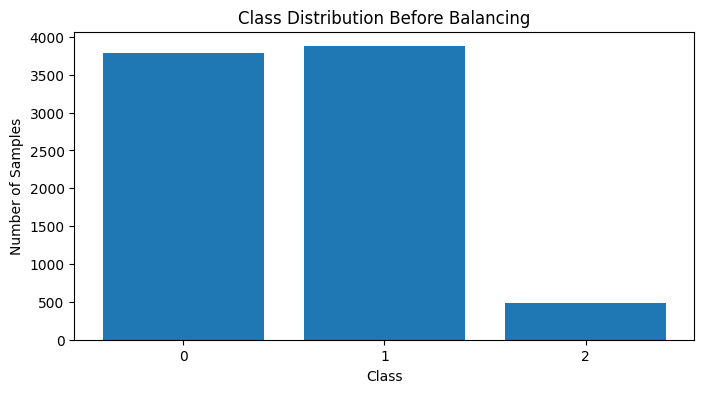

Class counts before balancing: [3791 3875  489]


In [15]:
import matplotlib.pyplot as plt

# Count the number of instances of each class before balancing
class_counts = torch.bincount(targets_combined)

# Plot the class distribution
plt.figure(figsize=(8, 4))
plt.bar(range(len(class_counts)), class_counts.numpy(), tick_label=list(range(len(class_counts))))
plt.title("Class Distribution Before Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

print("Class counts before balancing:", class_counts.numpy())

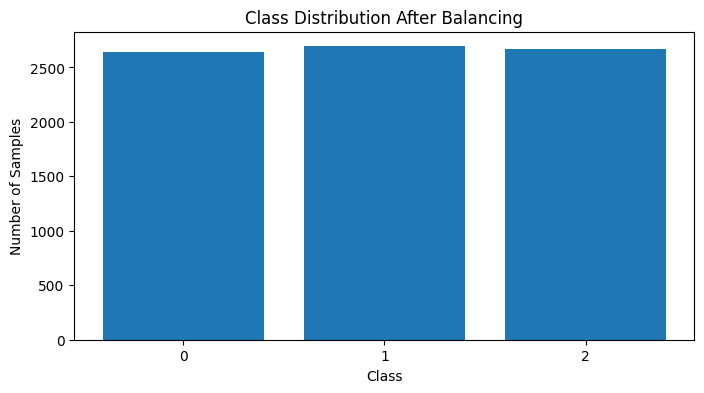

Class counts after balancing: [2641 2693 2666]


In [16]:
# Simulate sampling
num_samples_to_check = 8000  # You can increase this number for better accuracy
sampled_indices = list(sampler)[:num_samples_to_check]
sampled_targets = targets_combined[sampled_indices]

# Count the number of instances of each class after balancing
balanced_class_counts = torch.bincount(sampled_targets)

# Plot the class distribution after balancing
plt.figure(figsize=(8, 4))
plt.bar(range(len(balanced_class_counts)), balanced_class_counts.numpy(), tick_label=list(range(len(balanced_class_counts))))
plt.title("Class Distribution After Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

print("Class counts after balancing:", balanced_class_counts.numpy())

In [17]:
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets_combined['train'], batch_size = 32, sampler=sampler),
    'val': torch.utils.data.DataLoader(image_datasets_combined['val'], batch_size = 32),
    'test': torch.utils.data.DataLoader(image_datasets_combined['test'], batch_size = 32)
}

In [18]:
# # Check class distribution in your training set
# targets = []
# for _, labels in dataloaders['train']:
#     targets.extend(labels.cpu().numpy())
# print("Class distribution:", np.bincount(targets))

In [19]:
len(dataloaders['train'])

255

In [20]:
class NT_Xent(nn.Module):
    def __init__(self, temperature: float = 0.5, **kwargs):
        super().__init__()
        self.temperature = temperature
        self.eps = 1e-8
        if abs(self.temperature) < self.eps:
            raise ValueError(
                "Illegal temperature: abs({}) < 1e-8".format(self.temperature)
            )

    def forward(self, out0: torch.Tensor, out1: torch.Tensor):
        device = out0.device
        batch_size, _ = out0.shape

        out0 = nn.functional.normalize(out0, dim=1)
        out1 = nn.functional.normalize(out1, dim=1)

        out = torch.cat((out0, out1), dim=0)
        sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / self.temperature)
        mask = (
            torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=device)
        ).bool()
        sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)
        pos_sim = torch.exp(torch.sum(out0 * out1, dim=-1) / self.temperature)
        pos_sim = torch.cat((pos_sim, pos_sim), dim=0)
        loss = (-torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean()
        return loss

In [21]:
class SimCLR(nn.Module):

    def __init__(
        self,
        backbone: nn.Module,
        feature_size: int,
        projection_dim: int = 128,
        **kwargs
    ):
        super().__init__()
        self.feature_size = feature_size
        self.projection_dim = projection_dim
        self.backbone = backbone

        self.projection_head = nn.Sequential(
            nn.Sequential(nn.Linear(self.feature_size, self.feature_size), nn.BatchNorm1d(self.feature_size), nn.ReLU(inplace=True)),
            nn.Sequential(nn.Linear(self.feature_size, self.feature_size), nn.BatchNorm1d(self.feature_size), nn.ReLU(inplace=True)),
            nn.Sequential(nn.Linear(self.feature_size, self.feature_size), nn.BatchNorm1d(self.feature_size)))

        self.encoder = nn.Sequential(self.backbone, self.projection_head)

    def forward(self, x0: torch.Tensor, x1: torch.Tensor):
        f0 = self.backbone(x0).flatten(start_dim=1)
        out0 = self.projection_head(f0)

        f1 = self.backbone(x1).flatten(start_dim=1)
        out1 = self.projection_head(f1)

        return out0, out1

In [22]:
backbone = models.resnet50()
num_features = backbone.fc.in_features
backbone.fc = nn.Identity()

model = SimCLR(backbone=backbone, feature_size=num_features, projection_dim=128)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [23]:
print(f"Number of Model Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Memmory Usage: {torch.cuda.memory_allocated(device) / 1024**3:.2f} GB")

Number of Model Parameters: 36109376
Memmory Usage: 0.13 GB


In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = NT_Xent()
ssl_transform = SimCLRViewTransform()

### SSL Training

In [27]:
import torch
import pickle
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import os

# Create a directory to save your models and metrics
save_dir = '/kaggle/working/checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Path to the metrics file
metrics_path = os.path.join(save_dir, 'training_metrics_ssl_simCLR.pkl')

# Load existing metrics if the file exists
try:
    with open(metrics_path, "rb") as f:
        metrics = pickle.load(f)
except FileNotFoundError:
    # If the file doesn't exist, initialize empty metrics
    metrics = {
        'train_loss': [],
        'val_loss': [],
    }

# Parameters for Early Stopping
early_stopping_patience = 5  # Stop after 5 epochs with no improvement
best_val_loss = float('inf')
patience_counter = 0

num_epochs = 100  # Set a higher number of epochs to allow early stopping

# Load the model checkpoint if it exists
checkpoint_path = os.path.join(save_dir, 'model_ssl_epoch_99.pth')
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print(f"Loaded checkpoint from {checkpoint_path}")

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            dataloader = dataloaders['train']
        else:
            model.eval()  # Set model to evaluate mode
            dataloader = dataloaders['val']

        running_loss = 0.0

        # Iterate over data with tqdm progress bar
        for inputs, _ in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
            inputs = inputs.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            aug1 = ssl_transform(inputs)
            aug2 = ssl_transform(inputs)

            # Forward pass
            with torch.set_grad_enabled(phase == 'train'):
                out0, out1 = model(aug1, aug2)
                loss = criterion(out0, out1)

                # Backward pass + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)

        # Calculate metrics
        epoch_loss = running_loss / len(dataloader.dataset)

        # Append the current epoch's loss to the corresponding list
        metrics[f'{phase}_loss'].append(epoch_loss)

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}')

        # Early stopping check during validation phase
        if phase == 'val':
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                patience_counter = 0  # Reset the counter if improvement occurs
                # Save the model weights when improvement occurs
                torch.save(model.state_dict(), os.path.join(save_dir, 'best_model_ssl_training.pth'))
                print(f"Saved best model at epoch {epoch+1}")
            else:
                patience_counter += 1

        if (epoch + 1) % 10 == 0:
            # Save the model weights every 10 epochs
            torch.save(model.state_dict(), os.path.join(save_dir, f'model_ssl_epoch_{epoch}.pth'))
            print(f"Saved model checkpoint at epoch {epoch+1}")

    print()

    # Check for early stopping
#     if patience_counter >= early_stopping_patience:
#         print("Early stopping triggered")
#         break

# Save updated metrics back to the pickle file
with open(metrics_path, "wb") as f:
    pickle.dump(metrics, f)

print(f"Training metrics saved to {metrics_path}")


Epoch 1/100
----------


Train Phase: 100%|██████████| 255/255 [06:05<00:00,  1.43s/it]


Train Loss: 2.7147


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Val Loss: 4.3073
Saved best model at epoch 1

Epoch 2/100
----------


Train Phase: 100%|██████████| 255/255 [06:01<00:00,  1.42s/it]


Train Loss: 2.6843


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.08it/s]


Val Loss: 4.4007

Epoch 3/100
----------


Train Phase: 100%|██████████| 255/255 [05:52<00:00,  1.38s/it]


Train Loss: 2.6751


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Val Loss: 4.4642

Epoch 4/100
----------


Train Phase: 100%|██████████| 255/255 [05:47<00:00,  1.36s/it]


Train Loss: 2.6677


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Val Loss: 4.5241

Epoch 5/100
----------


Train Phase: 100%|██████████| 255/255 [05:59<00:00,  1.41s/it]


Train Loss: 2.6220


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Val Loss: 4.6536

Epoch 6/100
----------


Train Phase: 100%|██████████| 255/255 [05:41<00:00,  1.34s/it]


Train Loss: 2.6285


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Val Loss: 4.5477

Epoch 7/100
----------


Train Phase: 100%|██████████| 255/255 [05:53<00:00,  1.39s/it]


Train Loss: 2.6372


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Val Loss: 4.4725

Epoch 8/100
----------


Train Phase: 100%|██████████| 255/255 [05:41<00:00,  1.34s/it]


Train Loss: 2.6198


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Val Loss: 4.5841

Epoch 9/100
----------


Train Phase: 100%|██████████| 255/255 [05:59<00:00,  1.41s/it]


Train Loss: 2.6403


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.10it/s]


Val Loss: 4.4325

Epoch 10/100
----------


Train Phase: 100%|██████████| 255/255 [05:56<00:00,  1.40s/it]


Train Loss: 2.6070
Saved model checkpoint at epoch 10


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Val Loss: 4.4258
Saved model checkpoint at epoch 10

Epoch 11/100
----------


Train Phase: 100%|██████████| 255/255 [05:36<00:00,  1.32s/it]


Train Loss: 2.5809


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Val Loss: 4.5382

Epoch 12/100
----------


Train Phase: 100%|██████████| 255/255 [05:40<00:00,  1.33s/it]


Train Loss: 2.5552


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Val Loss: 4.4316

Epoch 13/100
----------


Train Phase: 100%|██████████| 255/255 [05:57<00:00,  1.40s/it]


Train Loss: 2.5610


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Val Loss: 4.5286

Epoch 14/100
----------


Train Phase: 100%|██████████| 255/255 [05:52<00:00,  1.38s/it]


Train Loss: 2.6008


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Val Loss: 4.2973
Saved best model at epoch 14

Epoch 15/100
----------


Train Phase: 100%|██████████| 255/255 [05:57<00:00,  1.40s/it]


Train Loss: 2.5600


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Val Loss: 4.4055

Epoch 16/100
----------


Train Phase: 100%|██████████| 255/255 [05:59<00:00,  1.41s/it]


Train Loss: 2.5521


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Val Loss: 4.3720

Epoch 17/100
----------


Train Phase: 100%|██████████| 255/255 [05:40<00:00,  1.34s/it]


Train Loss: 2.5389


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.4354

Epoch 18/100
----------


Train Phase: 100%|██████████| 255/255 [06:04<00:00,  1.43s/it]


Train Loss: 2.5578


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.3738

Epoch 19/100
----------


Train Phase: 100%|██████████| 255/255 [05:50<00:00,  1.37s/it]


Train Loss: 2.5259


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.07it/s]


Val Loss: 4.3224

Epoch 20/100
----------


Train Phase: 100%|██████████| 255/255 [05:54<00:00,  1.39s/it]


Train Loss: 2.5471
Saved model checkpoint at epoch 20


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


Val Loss: 4.3900
Saved model checkpoint at epoch 20

Epoch 21/100
----------


Train Phase: 100%|██████████| 255/255 [05:28<00:00,  1.29s/it]


Train Loss: 2.5286


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.4014

Epoch 22/100
----------


Train Phase: 100%|██████████| 255/255 [05:54<00:00,  1.39s/it]


Train Loss: 2.5190


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Val Loss: 4.3268

Epoch 23/100
----------


Train Phase: 100%|██████████| 255/255 [05:41<00:00,  1.34s/it]


Train Loss: 2.5352


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


Val Loss: 4.4592

Epoch 24/100
----------


Train Phase: 100%|██████████| 255/255 [05:33<00:00,  1.31s/it]


Train Loss: 2.5070


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Val Loss: 4.3366

Epoch 25/100
----------


Train Phase: 100%|██████████| 255/255 [05:51<00:00,  1.38s/it]


Train Loss: 2.5332


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Val Loss: 4.4166

Epoch 26/100
----------


Train Phase: 100%|██████████| 255/255 [05:55<00:00,  1.39s/it]


Train Loss: 2.5104


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


Val Loss: 4.3527

Epoch 27/100
----------


Train Phase: 100%|██████████| 255/255 [05:57<00:00,  1.40s/it]


Train Loss: 2.5143


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.4078

Epoch 28/100
----------


Train Phase: 100%|██████████| 255/255 [05:37<00:00,  1.33s/it]


Train Loss: 2.5288


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.10it/s]


Val Loss: 4.3709

Epoch 29/100
----------


Train Phase: 100%|██████████| 255/255 [05:51<00:00,  1.38s/it]


Train Loss: 2.4872


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.3641

Epoch 30/100
----------


Train Phase: 100%|██████████| 255/255 [05:56<00:00,  1.40s/it]


Train Loss: 2.4969
Saved model checkpoint at epoch 30


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


Val Loss: 4.5432
Saved model checkpoint at epoch 30

Epoch 31/100
----------


Train Phase: 100%|██████████| 255/255 [06:02<00:00,  1.42s/it]


Train Loss: 2.4946


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Val Loss: 4.3022

Epoch 32/100
----------


Train Phase: 100%|██████████| 255/255 [05:50<00:00,  1.37s/it]


Train Loss: 2.5087


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Val Loss: 4.2362
Saved best model at epoch 32

Epoch 33/100
----------


Train Phase: 100%|██████████| 255/255 [05:39<00:00,  1.33s/it]


Train Loss: 2.4919


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.3998

Epoch 34/100
----------


Train Phase: 100%|██████████| 255/255 [05:41<00:00,  1.34s/it]


Train Loss: 2.4683


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Val Loss: 4.4319

Epoch 35/100
----------


Train Phase: 100%|██████████| 255/255 [05:52<00:00,  1.38s/it]


Train Loss: 2.5021


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


Val Loss: 4.2719

Epoch 36/100
----------


Train Phase: 100%|██████████| 255/255 [05:43<00:00,  1.35s/it]


Train Loss: 2.4897


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Val Loss: 4.4595

Epoch 37/100
----------


Train Phase: 100%|██████████| 255/255 [05:43<00:00,  1.35s/it]


Train Loss: 2.5042


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Val Loss: 4.4940

Epoch 38/100
----------


Train Phase: 100%|██████████| 255/255 [05:42<00:00,  1.34s/it]


Train Loss: 2.5143


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Val Loss: 4.2791

Epoch 39/100
----------


Train Phase: 100%|██████████| 255/255 [05:37<00:00,  1.32s/it]


Train Loss: 2.4871


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Val Loss: 4.3302

Epoch 40/100
----------


Train Phase: 100%|██████████| 255/255 [05:37<00:00,  1.32s/it]


Train Loss: 2.4688
Saved model checkpoint at epoch 40


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Val Loss: 4.2236
Saved best model at epoch 40
Saved model checkpoint at epoch 40

Epoch 41/100
----------


Train Phase: 100%|██████████| 255/255 [05:56<00:00,  1.40s/it]


Train Loss: 2.4780


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Val Loss: 4.4243

Epoch 42/100
----------


Train Phase: 100%|██████████| 255/255 [05:34<00:00,  1.31s/it]


Train Loss: 2.4769


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


Val Loss: 4.5326

Epoch 43/100
----------


Train Phase: 100%|██████████| 255/255 [05:47<00:00,  1.36s/it]


Train Loss: 2.4620


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


Val Loss: 4.5280

Epoch 44/100
----------


Train Phase: 100%|██████████| 255/255 [05:49<00:00,  1.37s/it]


Train Loss: 2.4857


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.4312

Epoch 45/100
----------


Train Phase: 100%|██████████| 255/255 [05:37<00:00,  1.32s/it]


Train Loss: 2.4691


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.3593

Epoch 46/100
----------


Train Phase: 100%|██████████| 255/255 [05:56<00:00,  1.40s/it]


Train Loss: 2.4962


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Val Loss: 4.3679

Epoch 47/100
----------


Train Phase: 100%|██████████| 255/255 [06:00<00:00,  1.41s/it]


Train Loss: 2.4694


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Val Loss: 4.4486

Epoch 48/100
----------


Train Phase: 100%|██████████| 255/255 [05:55<00:00,  1.40s/it]


Train Loss: 2.4730


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Val Loss: 4.3833

Epoch 49/100
----------


Train Phase: 100%|██████████| 255/255 [05:51<00:00,  1.38s/it]


Train Loss: 2.4540


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Val Loss: 4.2909

Epoch 50/100
----------


Train Phase: 100%|██████████| 255/255 [06:01<00:00,  1.42s/it]


Train Loss: 2.4612
Saved model checkpoint at epoch 50


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.04it/s]


Val Loss: 4.3750
Saved model checkpoint at epoch 50

Epoch 51/100
----------


Train Phase: 100%|██████████| 255/255 [05:57<00:00,  1.40s/it]


Train Loss: 2.4508


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Val Loss: 4.3018

Epoch 52/100
----------


Train Phase: 100%|██████████| 255/255 [05:50<00:00,  1.37s/it]


Train Loss: 2.4427


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Val Loss: 4.3352

Epoch 53/100
----------


Train Phase: 100%|██████████| 255/255 [06:13<00:00,  1.46s/it]


Train Loss: 2.4472


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Val Loss: 4.3938

Epoch 54/100
----------


Train Phase: 100%|██████████| 255/255 [05:49<00:00,  1.37s/it]


Train Loss: 2.4470


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.3033

Epoch 55/100
----------


Train Phase: 100%|██████████| 255/255 [05:29<00:00,  1.29s/it]


Train Loss: 2.4607


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Val Loss: 4.4060

Epoch 56/100
----------


Train Phase: 100%|██████████| 255/255 [05:51<00:00,  1.38s/it]


Train Loss: 2.4478


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Val Loss: 4.2919

Epoch 57/100
----------


Train Phase: 100%|██████████| 255/255 [05:56<00:00,  1.40s/it]


Train Loss: 2.4298


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Val Loss: 4.2386

Epoch 58/100
----------


Train Phase: 100%|██████████| 255/255 [05:57<00:00,  1.40s/it]


Train Loss: 2.4683


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Val Loss: 4.3397

Epoch 59/100
----------


Train Phase: 100%|██████████| 255/255 [05:50<00:00,  1.38s/it]


Train Loss: 2.4339


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


Val Loss: 4.4946

Epoch 60/100
----------


Train Phase: 100%|██████████| 255/255 [05:52<00:00,  1.38s/it]


Train Loss: 2.4505
Saved model checkpoint at epoch 60


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.2809
Saved model checkpoint at epoch 60

Epoch 61/100
----------


Train Phase: 100%|██████████| 255/255 [05:50<00:00,  1.37s/it]


Train Loss: 2.4410


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.09it/s]


Val Loss: 4.5037

Epoch 62/100
----------


Train Phase: 100%|██████████| 255/255 [05:42<00:00,  1.34s/it]


Train Loss: 2.4328


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s]


Val Loss: 4.2885

Epoch 63/100
----------


Train Phase: 100%|██████████| 255/255 [05:50<00:00,  1.37s/it]


Train Loss: 2.4404


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Val Loss: 4.3457

Epoch 64/100
----------


Train Phase: 100%|██████████| 255/255 [05:37<00:00,  1.32s/it]


Train Loss: 2.4265


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Val Loss: 4.3004

Epoch 65/100
----------


Train Phase: 100%|██████████| 255/255 [05:49<00:00,  1.37s/it]


Train Loss: 2.4494


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.10it/s]


Val Loss: 4.5335

Epoch 66/100
----------


Train Phase: 100%|██████████| 255/255 [05:41<00:00,  1.34s/it]


Train Loss: 2.4329


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.11it/s]


Val Loss: 4.3303

Epoch 67/100
----------


Train Phase: 100%|██████████| 255/255 [06:04<00:00,  1.43s/it]


Train Loss: 2.4308


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.3548

Epoch 68/100
----------


Train Phase: 100%|██████████| 255/255 [05:25<00:00,  1.28s/it]


Train Loss: 2.4402


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.2942

Epoch 69/100
----------


Train Phase: 100%|██████████| 255/255 [05:56<00:00,  1.40s/it]


Train Loss: 2.4384


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


Val Loss: 4.2186
Saved best model at epoch 69

Epoch 70/100
----------


Train Phase: 100%|██████████| 255/255 [05:58<00:00,  1.41s/it]


Train Loss: 2.4390
Saved model checkpoint at epoch 70


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.4853
Saved model checkpoint at epoch 70

Epoch 71/100
----------


Train Phase: 100%|██████████| 255/255 [05:58<00:00,  1.40s/it]


Train Loss: 2.4292


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.2861

Epoch 72/100
----------


Train Phase: 100%|██████████| 255/255 [05:53<00:00,  1.38s/it]


Train Loss: 2.4309


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.3451

Epoch 73/100
----------


Train Phase: 100%|██████████| 255/255 [05:49<00:00,  1.37s/it]


Train Loss: 2.4350


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.4004

Epoch 74/100
----------


Train Phase: 100%|██████████| 255/255 [05:45<00:00,  1.35s/it]


Train Loss: 2.4371


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.2497

Epoch 75/100
----------


Train Phase: 100%|██████████| 255/255 [05:37<00:00,  1.32s/it]


Train Loss: 2.4423


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.10it/s]


Val Loss: 4.2702

Epoch 76/100
----------


Train Phase: 100%|██████████| 255/255 [05:49<00:00,  1.37s/it]


Train Loss: 2.4336


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


Val Loss: 4.3095

Epoch 77/100
----------


Train Phase: 100%|██████████| 255/255 [05:52<00:00,  1.38s/it]


Train Loss: 2.4312


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.10it/s]


Val Loss: 4.2612

Epoch 78/100
----------


Train Phase: 100%|██████████| 255/255 [05:35<00:00,  1.32s/it]


Train Loss: 2.4061


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.08it/s]


Val Loss: 4.3534

Epoch 79/100
----------


Train Phase: 100%|██████████| 255/255 [06:01<00:00,  1.42s/it]


Train Loss: 2.4307


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.12it/s]


Val Loss: 4.2403

Epoch 80/100
----------


Train Phase: 100%|██████████| 255/255 [05:47<00:00,  1.36s/it]


Train Loss: 2.4006
Saved model checkpoint at epoch 80


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


Val Loss: 4.3151
Saved model checkpoint at epoch 80

Epoch 81/100
----------


Train Phase: 100%|██████████| 255/255 [05:33<00:00,  1.31s/it]


Train Loss: 2.4235


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Val Loss: 4.2797

Epoch 82/100
----------


Train Phase: 100%|██████████| 255/255 [05:58<00:00,  1.40s/it]


Train Loss: 2.4264


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s]


Val Loss: 4.3873

Epoch 83/100
----------


Train Phase: 100%|██████████| 255/255 [05:51<00:00,  1.38s/it]


Train Loss: 2.4253


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


Val Loss: 4.3230

Epoch 84/100
----------


Train Phase: 100%|██████████| 255/255 [05:33<00:00,  1.31s/it]


Train Loss: 2.4019


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


Val Loss: 4.3922

Epoch 85/100
----------


Train Phase: 100%|██████████| 255/255 [05:32<00:00,  1.30s/it]


Train Loss: 2.4216


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.15it/s]


Val Loss: 4.4931

Epoch 86/100
----------


Train Phase: 100%|██████████| 255/255 [05:56<00:00,  1.40s/it]


Train Loss: 2.3944


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  1.97it/s]


Val Loss: 4.3616

Epoch 87/100
----------


Train Phase: 100%|██████████| 255/255 [05:44<00:00,  1.35s/it]


Train Loss: 2.4154


Val Phase: 100%|██████████| 21/21 [00:11<00:00,  1.91it/s]


Val Loss: 4.2682

Epoch 88/100
----------


Train Phase: 100%|██████████| 255/255 [05:40<00:00,  1.34s/it]


Train Loss: 2.4075


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  1.93it/s]


Val Loss: 4.2857

Epoch 89/100
----------


Train Phase: 100%|██████████| 255/255 [06:04<00:00,  1.43s/it]


Train Loss: 2.4296


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  1.94it/s]


Val Loss: 4.2431

Epoch 90/100
----------


Train Phase: 100%|██████████| 255/255 [06:30<00:00,  1.53s/it]


Train Loss: 2.4120
Saved model checkpoint at epoch 90


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.00it/s]


Val Loss: 4.4649
Saved model checkpoint at epoch 90

Epoch 91/100
----------


Train Phase: 100%|██████████| 255/255 [05:57<00:00,  1.40s/it]


Train Loss: 2.4007


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.02it/s]


Val Loss: 4.2278

Epoch 92/100
----------


Train Phase: 100%|██████████| 255/255 [05:48<00:00,  1.37s/it]


Train Loss: 2.4050


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  1.98it/s]


Val Loss: 4.2736

Epoch 93/100
----------


Train Phase: 100%|██████████| 255/255 [06:06<00:00,  1.44s/it]


Train Loss: 2.4123


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  1.94it/s]


Val Loss: 4.2978

Epoch 94/100
----------


Train Phase: 100%|██████████| 255/255 [06:09<00:00,  1.45s/it]


Train Loss: 2.4297


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  1.97it/s]


Val Loss: 4.2047
Saved best model at epoch 94

Epoch 95/100
----------


Train Phase: 100%|██████████| 255/255 [06:04<00:00,  1.43s/it]


Train Loss: 2.4067


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  1.94it/s]


Val Loss: 4.3162

Epoch 96/100
----------


Train Phase: 100%|██████████| 255/255 [06:10<00:00,  1.45s/it]


Train Loss: 2.4266


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  1.93it/s]


Val Loss: 4.3114

Epoch 97/100
----------


Train Phase: 100%|██████████| 255/255 [06:03<00:00,  1.42s/it]


Train Loss: 2.4022


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  1.99it/s]


Val Loss: 4.2101

Epoch 98/100
----------


Train Phase: 100%|██████████| 255/255 [05:51<00:00,  1.38s/it]


Train Loss: 2.4085


Val Phase: 100%|██████████| 21/21 [00:11<00:00,  1.88it/s]


Val Loss: 4.3676

Epoch 99/100
----------


Train Phase: 100%|██████████| 255/255 [06:11<00:00,  1.46s/it]


Train Loss: 2.3966


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  1.98it/s]


Val Loss: 4.2750

Epoch 100/100
----------


Train Phase: 100%|██████████| 255/255 [05:52<00:00,  1.38s/it]


Train Loss: 2.4181
Saved model checkpoint at epoch 100


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  1.96it/s]


Val Loss: 4.2849
Saved model checkpoint at epoch 100

Training metrics saved to /kaggle/working/checkpoints/training_metrics_ssl_simCLR.pkl


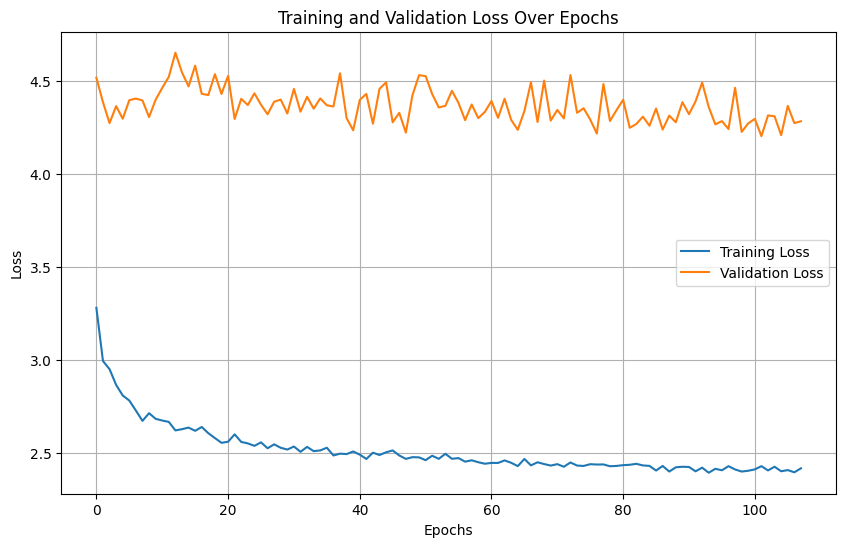

In [30]:
import pickle
import matplotlib.pyplot as plt
import os

# Set the path to your metrics file saved in the Kaggle environment
# metrics_path = '/kaggle/working/training_metrics_ssl_simCLR.pkl'  # Update this path if needed
metrics_path = '/kaggle/working/checkpoints/training_metrics_ssl_simCLR.pkl'  # Updated the path

# Load the saved metrics
with open(metrics_path, "rb") as f:
    metrics = pickle.load(f)

# Extract the metrics
train_loss = metrics['train_loss']
val_loss = metrics['val_loss']

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pickle  # To save the metrics
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, f1_score
import os

# Directory to save your models and metrics in Kaggle
save_dir = '/kaggle/working/checkpoints'
os.makedirs(save_dir, exist_ok=True)

# Freeze the backbone
for param in model.backbone.parameters():
    param.requires_grad = False

# Replace the backbone's classifier with a new linear layer
num_classes = 3  # Number of classes in your dataset
model.backbone.fc = nn.Linear(num_features, num_classes)
model = model.backbone.to(device)

# Define loss function and optimizer for the linear classifier
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Evaluation loop
num_epochs_linear = 100  # Adjust as needed
loss_history = []  # To store the loss at each epoch
accuracy_history = []  # To store accuracy at each epoch
precision_history = []  # To store precision at each epoch
f1_history = []  # To store F1 score at each epoch

for epoch in range(num_epochs_linear):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(dataloaders['train'], desc=f"Linear Eval Epoch {epoch+1}"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # Collect predictions and labels for metrics
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloaders['train'].dataset)
    epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

    # Calculate precision and F1 score
    epoch_precision = precision_score(all_labels, all_preds, average='macro')
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    # Save metrics history
    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_acc.item())
    precision_history.append(epoch_precision)
    f1_history.append(epoch_f1)

    # Save every 10 epochs (or adjust as needed)
    if (epoch + 1) % 10 == 0:
        with open(os.path.join(save_dir, 'metrics_history.pkl'), 'wb') as f:
            pickle.dump({
                'loss': loss_history,
                'accuracy': accuracy_history,
                'precision': precision_history,
                'f1': f1_history
            }, f)
        
        # Save model checkpoint
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_ssl_epoch_{epoch}.pth'))

    print(f"Linear Eval Epoch {epoch+1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} F1: {epoch_f1:.4f}")

# Validation on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate evaluation metrics on test set
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Set - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


Linear Eval Epoch 1: 100%|██████████| 255/255 [02:16<00:00,  1.87it/s]


Linear Eval Epoch 1 Loss: 0.2976 Acc: 0.9034 Precision: 0.9054 F1: 0.9043


Linear Eval Epoch 2: 100%|██████████| 255/255 [02:15<00:00,  1.88it/s]


Linear Eval Epoch 2 Loss: 0.1797 Acc: 0.9372 Precision: 0.9376 F1: 0.9375


Linear Eval Epoch 3: 100%|██████████| 255/255 [02:12<00:00,  1.92it/s]


Linear Eval Epoch 3 Loss: 0.1555 Acc: 0.9418 Precision: 0.9418 F1: 0.9417


Linear Eval Epoch 4: 100%|██████████| 255/255 [02:15<00:00,  1.89it/s]


Linear Eval Epoch 4 Loss: 0.1433 Acc: 0.9463 Precision: 0.9462 F1: 0.9462


Linear Eval Epoch 5: 100%|██████████| 255/255 [02:16<00:00,  1.87it/s]


Linear Eval Epoch 5 Loss: 0.1386 Acc: 0.9479 Precision: 0.9483 F1: 0.9482


Linear Eval Epoch 6: 100%|██████████| 255/255 [02:16<00:00,  1.87it/s]


Linear Eval Epoch 6 Loss: 0.1265 Acc: 0.9556 Precision: 0.9554 F1: 0.9554


Linear Eval Epoch 7: 100%|██████████| 255/255 [02:14<00:00,  1.89it/s]


Linear Eval Epoch 7 Loss: 0.1342 Acc: 0.9489 Precision: 0.9489 F1: 0.9489


Linear Eval Epoch 8: 100%|██████████| 255/255 [02:15<00:00,  1.89it/s]


Linear Eval Epoch 8 Loss: 0.1148 Acc: 0.9573 Precision: 0.9572 F1: 0.9572


Linear Eval Epoch 9: 100%|██████████| 255/255 [02:15<00:00,  1.89it/s]


Linear Eval Epoch 9 Loss: 0.1328 Acc: 0.9487 Precision: 0.9486 F1: 0.9485


Linear Eval Epoch 10: 100%|██████████| 255/255 [02:14<00:00,  1.89it/s]


Linear Eval Epoch 10 Loss: 0.1254 Acc: 0.9539 Precision: 0.9542 F1: 0.9541


Linear Eval Epoch 11: 100%|██████████| 255/255 [02:13<00:00,  1.92it/s]


Linear Eval Epoch 11 Loss: 0.1194 Acc: 0.9577 Precision: 0.9576 F1: 0.9575


Linear Eval Epoch 12: 100%|██████████| 255/255 [02:13<00:00,  1.91it/s]


Linear Eval Epoch 12 Loss: 0.1098 Acc: 0.9561 Precision: 0.9562 F1: 0.9562


Linear Eval Epoch 13: 100%|██████████| 255/255 [02:13<00:00,  1.91it/s]


Linear Eval Epoch 13 Loss: 0.1103 Acc: 0.9594 Precision: 0.9592 F1: 0.9592


Linear Eval Epoch 14: 100%|██████████| 255/255 [02:13<00:00,  1.92it/s]


Linear Eval Epoch 14 Loss: 0.1145 Acc: 0.9577 Precision: 0.9577 F1: 0.9577


Linear Eval Epoch 15: 100%|██████████| 255/255 [02:12<00:00,  1.93it/s]


Linear Eval Epoch 15 Loss: 0.1204 Acc: 0.9530 Precision: 0.9530 F1: 0.9530


Linear Eval Epoch 16: 100%|██████████| 255/255 [02:14<00:00,  1.89it/s]


Linear Eval Epoch 16 Loss: 0.1111 Acc: 0.9600 Precision: 0.9601 F1: 0.9601


Linear Eval Epoch 17: 100%|██████████| 255/255 [02:16<00:00,  1.87it/s]


Linear Eval Epoch 17 Loss: 0.1102 Acc: 0.9563 Precision: 0.9561 F1: 0.9561


Linear Eval Epoch 18: 100%|██████████| 255/255 [02:14<00:00,  1.90it/s]


Linear Eval Epoch 18 Loss: 0.1097 Acc: 0.9613 Precision: 0.9611 F1: 0.9610


Linear Eval Epoch 19: 100%|██████████| 255/255 [02:13<00:00,  1.91it/s]


Linear Eval Epoch 19 Loss: 0.1121 Acc: 0.9574 Precision: 0.9574 F1: 0.9573


Linear Eval Epoch 20: 100%|██████████| 255/255 [02:11<00:00,  1.94it/s]


Linear Eval Epoch 20 Loss: 0.1150 Acc: 0.9557 Precision: 0.9557 F1: 0.9557


Linear Eval Epoch 21: 100%|██████████| 255/255 [02:10<00:00,  1.95it/s]


Linear Eval Epoch 21 Loss: 0.0998 Acc: 0.9599 Precision: 0.9598 F1: 0.9598


Linear Eval Epoch 22: 100%|██████████| 255/255 [02:09<00:00,  1.97it/s]


Linear Eval Epoch 22 Loss: 0.0948 Acc: 0.9660 Precision: 0.9661 F1: 0.9660


Linear Eval Epoch 23: 100%|██████████| 255/255 [02:09<00:00,  1.96it/s]


Linear Eval Epoch 23 Loss: 0.1032 Acc: 0.9595 Precision: 0.9595 F1: 0.9595


Linear Eval Epoch 24: 100%|██████████| 255/255 [02:10<00:00,  1.95it/s]


Linear Eval Epoch 24 Loss: 0.0959 Acc: 0.9655 Precision: 0.9655 F1: 0.9655


Linear Eval Epoch 25:  68%|██████▊   | 174/255 [01:29<00:41,  1.94it/s]

In [ ]:
import pickle
import matplotlib.pyplot as plt
import os

# Set the path to your metrics file in the Kaggle environment
metrics_path = '/kaggle/working/metrics_history.pkl'  # Ensure this path matches where your metrics file is saved

# Load the saved metrics history
with open(metrics_path, 'rb') as f:
    metrics = pickle.load(f)
    loss_history = metrics['loss']
    accuracy_history = metrics['accuracy']
    precision_history = metrics['precision']
    f1_history = metrics['f1']

# Plot all metrics
epochs = range(1, len(loss_history) + 1)

plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, loss_history, marker='o', color='blue', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, accuracy_history, marker='o', color='green', label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Time')
plt.grid(True)

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(epochs, precision_history, marker='o', color='red', label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training Precision Over Time')
plt.grid(True)

# Plot F1 Score
plt.subplot(2, 2, 4)
plt.plot(epochs, f1_history, marker='o', color='purple', label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training F1 Score Over Time')
plt.grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()
